In [1]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
load_dotenv()

# from script.database_pipeline import Pipeline

import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Setting up DB

In [3]:
username = os.getenv('PSQL_USER')
password = os.getenv('PASS')
host = os.getenv('HOST')
port = os.getenv('PORT')

db_url = (f"postgresql+psycopg2://{username}:{password}@{host}:{port}/data_prof")

In [4]:
engine = create_engine(db_url)

In [5]:
# Converted into a csv
df = pd.read_csv('ds_2019.csv')

In [6]:
df.head()

,Survey Year,Timestamp,SalaryUSD,Country,PostalCode,PrimaryDatabase,YearsWithThisDatabase,OtherDatabases,EmploymentStatus,JobTitle,...,HoursWorkedPerWeek,TelecommuteDaysPerWeek,PopulationOfLargestCityWithin20Miles,EmploymentSector,LookingForAnotherJob,CareerPlansThisYear,Gender,OtherJobDuties,KindsOfTasksPerformed,Counter
0,2017,2017-01-05 05:10:20.451,200000,United States,Not Asked,Microsoft SQL Server,10,MySQL/MariaDB,Full time employee,DBA,...,45,1,Not Asked,Private business,"Yes, but only passively (just curious)",Not Asked,Not Asked,Not Asked,Not Asked,1
1,2017,2017-01-05 05:26:23.388,61515,United Kingdom,Not Asked,Microsoft SQL Server,15,"Oracle, PostgreSQL",Full time employee,DBA,...,35,2,Not Asked,Private business,No,Not Asked,Not Asked,Not Asked,Not Asked,1
2,2017,2017-01-05 05:32:57.367,95000,Germany,Not Asked,Microsoft SQL Server,5,"Oracle, MySQL/MariaDB, Informix",Full time employee,Other,...,45,"None, or less than 1 day per week",Not Asked,Private business,"Yes, but only passively (just curious)",Not Asked,Not Asked,Not Asked,Not Asked,1
3,2017,2017-01-05 05:33:03.316,56000,United Kingdom,Not Asked,Microsoft SQL Server,6,NaN,Full time employee,DBA,...,40,1,Not Asked,Private business,"Yes, but only passively (just curious)",Not Asked,Not Asked,Not Asked,Not Asked,1
4,2017,2017-01-05 05:34:33.866,35000,France,Not Asked,Microsoft SQL Server,10,Oracle,Full time employee of a consulting/contracting...,DBA,...,40,"None, or less than 1 day per week",Not Asked,Private business,"Yes, but only passively (just curious)",Not Asked,Not Asked,Not Asked,Not Asked,1


In [7]:
# pipe = Pipeline(engine)
# pipe.add_table(df, 'og')

### EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6893 entries, 0 to 6892
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Survey Year                           6893 non-null   int64 
 1   Timestamp                             6893 non-null   object
 2   SalaryUSD                             6893 non-null   object
 3   Country                               6893 non-null   object
 4   PostalCode                            5934 non-null   object
 5   PrimaryDatabase                       6893 non-null   object
 6   YearsWithThisDatabase                 6893 non-null   int64 
 7   OtherDatabases                        5520 non-null   object
 8   EmploymentStatus                      6893 non-null   object
 9   JobTitle                              6893 non-null   object
 10  ManageStaff                           6893 non-null   object
 11  YearsWithThisTypeOfJob        

In [9]:
df.isna().sum()

Survey Year                                0
Timestamp                                  0
SalaryUSD                                  0
Country                                    0
PostalCode                               959
PrimaryDatabase                            0
YearsWithThisDatabase                      0
OtherDatabases                          1373
EmploymentStatus                           0
JobTitle                                   0
ManageStaff                                0
YearsWithThisTypeOfJob                     0
HowManyCompanies                           0
OtherPeopleOnYourTeam                      0
CompanyEmployeesOverall                    0
DatabaseServers                            0
Education                                  0
EducationIsComputerRelated              1216
Certifications                             0
HoursWorkedPerWeek                         0
TelecommuteDaysPerWeek                     0
PopulationOfLargestCityWithin20Miles       0
Employment

In [10]:
countries = df['Country'].value_counts()
countries.head()

United States     4509
United Kingdom     667
Canada             244
Australia          185
India              112
Name: Country, dtype: int64

### Looking at US to start with

since majority of the data is in US

In [11]:
from script.helper import plot_quant, plot_cat

In [12]:
us = df[df['Country'] == 'United States']

In [13]:
us.isna().sum()

Survey Year                               0
Timestamp                                 0
SalaryUSD                                 0
Country                                   0
PostalCode                              302
PrimaryDatabase                           0
YearsWithThisDatabase                     0
OtherDatabases                          873
EmploymentStatus                          0
JobTitle                                  0
ManageStaff                               0
YearsWithThisTypeOfJob                    0
HowManyCompanies                          0
OtherPeopleOnYourTeam                     0
CompanyEmployeesOverall                   0
DatabaseServers                           0
Education                                 0
EducationIsComputerRelated              709
Certifications                            0
HoursWorkedPerWeek                        0
TelecommuteDaysPerWeek                    0
PopulationOfLargestCityWithin20Miles      0
EmploymentSector                

In [14]:
features = ['SalaryUSD', 'YearsWithThisDatabase', 'ManageStaff', 'YearsWithThisTypeOfJob', 'OtherPeopleOnYourTeam', 'Education', 'HoursWorkedPerWeek', 'TelecommuteDaysPerWeek', 'EmploymentSector']
target = ['LookingForAnotherJob']

### Salary

In [15]:
us.loc[:, 'SalaryUSD'] = us['SalaryUSD'].apply(str).str.replace(',|\s+', '', regex=True).astype(float)

/usr/local/anaconda3/envs/cap1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
us['SalaryUSD'].describe()

count    4.509000e+03
mean     1.075171e+05
std      5.717729e+04
min      9.227000e+01
25%      8.500000e+04
50%      1.020000e+05
75%      1.220000e+05
max      1.450000e+06
Name: SalaryUSD, dtype: float64

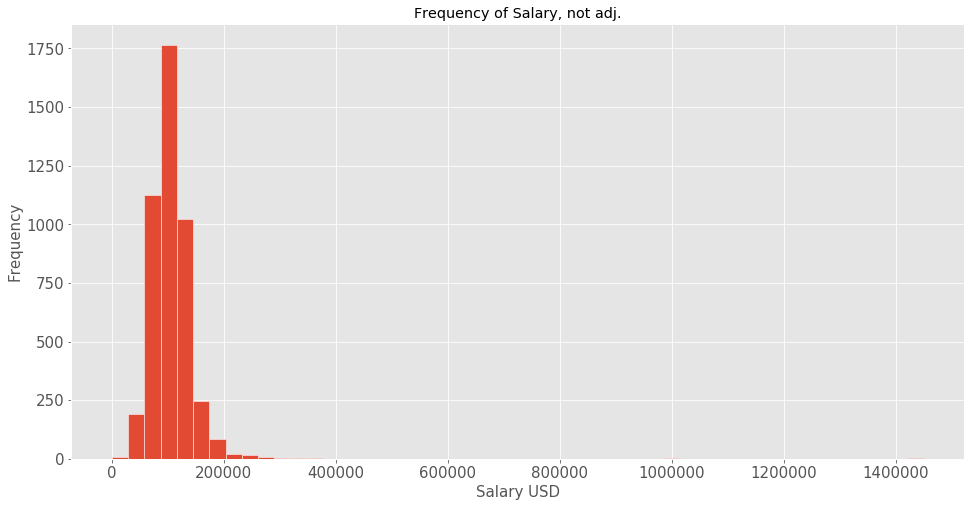

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))
(plot_quant(ax, us['SalaryUSD'], xlabel='Salary USD', ylabel='Frequency',
                 title='Frequency of Salary, not adj.', bins=50, edgecolor='white'))

### Remove salary outliers

In [18]:
salary = us['SalaryUSD']

In [19]:
salary.describe()

count    4.509000e+03
mean     1.075171e+05
std      5.717729e+04
min      9.227000e+01
25%      8.500000e+04
50%      1.020000e+05
75%      1.220000e+05
max      1.450000e+06
Name: SalaryUSD, dtype: float64

In [20]:
salary_q3 = salary.describe()['75%']
salary_q1 = salary.describe()['25%']

salary_iqr = salary_q3 - salary_q1
salary_adj = salary[(salary < (salary_q3 + 1.5 * salary_iqr)) & (salary > (salary_q1 - 1.5 * salary_iqr))]

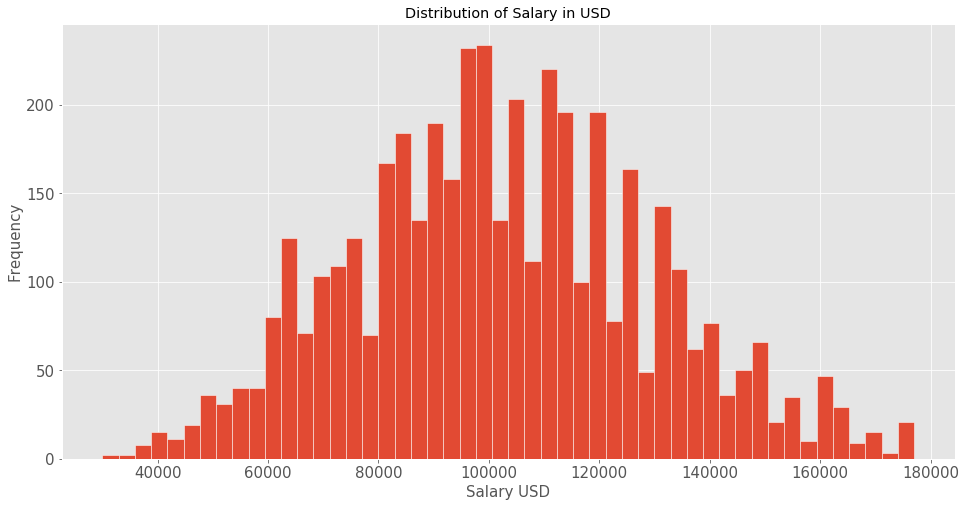

In [21]:
fig, ax = plt.subplots(figsize=(16, 8))
(plot_quant(ax, salary_adj, xlabel='Salary USD', ylabel='Frequency',
                 title='Distribution of Salary in USD', bins=50, edgecolor='white'))

### Years with this database

In [22]:
us['YearsWithThisDatabase'].value_counts()

10       486
15       432
20       369
5        304
4        241
17       232
3        231
8        226
7        222
18       221
12       219
6        216
2        163
16       155
13       111
1        109
11       100
9         99
14        88
25        61
19        58
21        43
22        42
23        29
24        13
30         9
0          6
28         6
26         5
27         4
32         2
2011       1
2000       1
2004       1
30331      1
38         1
53716      1
29         1
Name: YearsWithThisDatabase, dtype: int64

In [23]:
year_db = us['YearsWithThisDatabase']

In [24]:
yeardb_q3 = year_db.describe()['75%']
yeardb_q1 = year_db.describe()['25%']

yeardb_iqr = yeardb_q3 - yeardb_q1
yeardb_adj = year_db[(year_db < (yeardb_q3 + 1.5 * yeardb_iqr)) & (year_db > (yeardb_q1 - 1.5 * yeardb_iqr))]

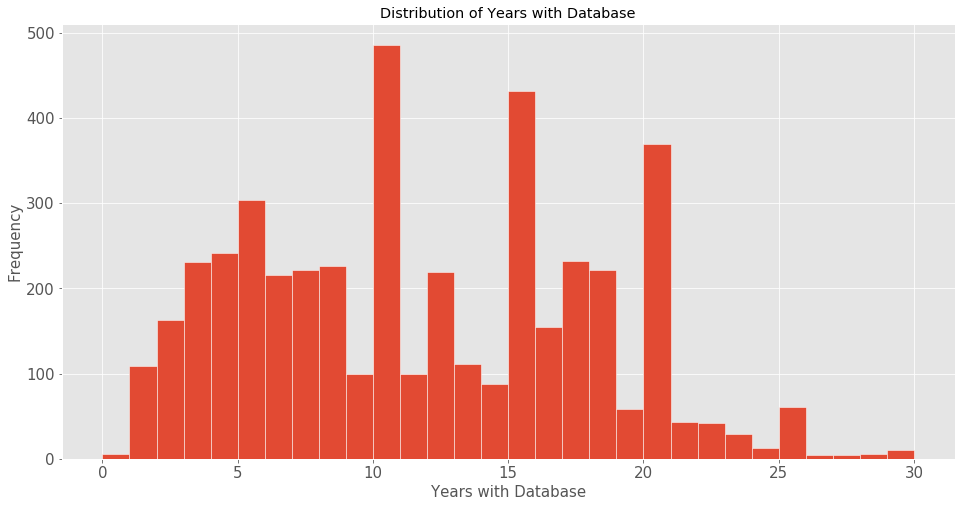

In [25]:
fig, ax = plt.subplots(figsize=(16, 8))
(plot_quant(ax, yeardb_adj, xlabel='Years with Database', ylabel='Frequency',
                 title='Distribution of Years with Database', bins=30, edgecolor='white'))

### Manage Staff

In [26]:
us['ManageStaff'].value_counts()

No     3498
Yes    1011
Name: ManageStaff, dtype: int64

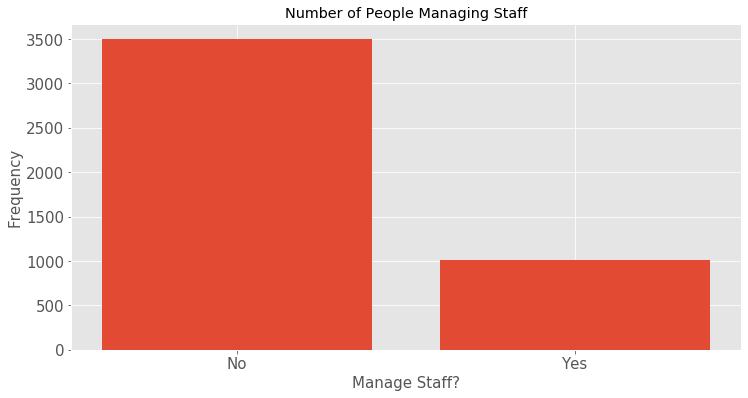

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, us['ManageStaff'].value_counts(), xlabel='Manage Staff?', ylabel='Frequency', 
              title='Number of People Managing Staff'))

### Years With This Type of Job

In [28]:
us['YearsWithThisTypeOfJob'].value_counts()

1     531
2     520
3     499
5     448
4     397
10    326
6     257
7     212
15    186
8     184
20    150
12    119
9      80
18     72
17     69
11     59
16     52
13     51
25     49
0      38
14     37
22     30
19     26
21     20
30     18
23     14
28     10
24      9
29      8
26      7
27      6
32      6
35      4
38      3
34      2
33      2
31      2
40      2
36      2
39      1
37      1
Name: YearsWithThisTypeOfJob, dtype: int64

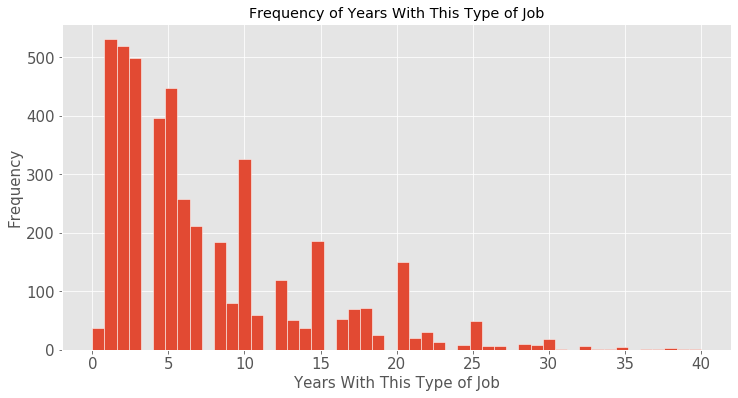

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_quant(ax, us['YearsWithThisTypeOfJob'], xlabel='Years With This Type of Job', ylabel='Frequency',
                        title='Frequency of Years With This Type of Job', bins=50, edgecolor='white'))

### Amount of Others on Your Team

Label Encode ordinality

In [30]:
us['OtherPeopleOnYourTeam'].value_counts()

None           1842
1               942
2               521
More than 5     422
3               378
4               239
5               165
Name: OtherPeopleOnYourTeam, dtype: int64

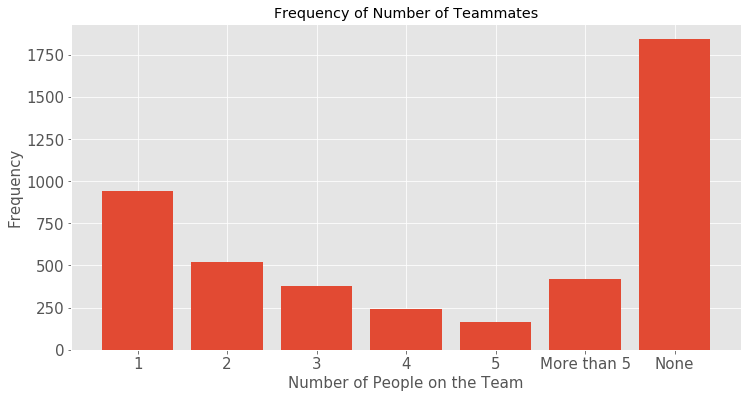

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))

(plot_cat(ax, us['OtherPeopleOnYourTeam'].value_counts().sort_index(), xlabel='Number of People on the Team', ylabel='Frequency',
                                         title='Frequency of Number of Teammates'))

### Education Level

Label Encode ordinality

In [32]:
us['Education'].value_counts()

Bachelors (4 years)           2548
Masters                        762
None (no degree completed)     672
Associates (2 years)           503
Doctorate/PhD                   24
Name: Education, dtype: int64

In [33]:
us.loc[:, 'Education'] = us['Education'].str.replace('\\(.*\\)', '', regex=True).str.strip()

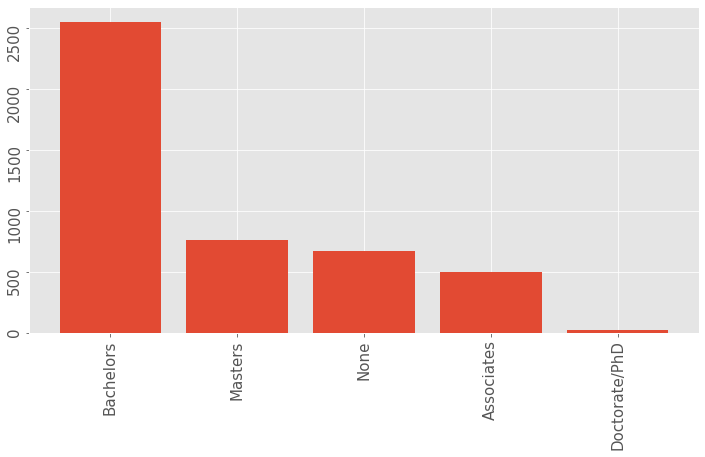

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, us['Education'].value_counts()))
ax.tick_params(rotation=90)

### Hours Work Per Week

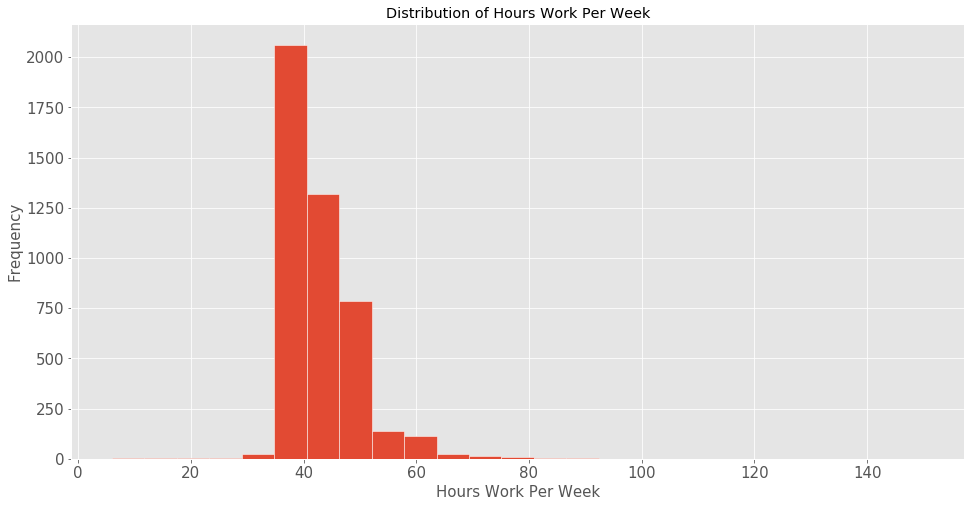

In [35]:
fig, ax = plt.subplots(figsize=(16, 8))
(plot_quant(ax, us['HoursWorkedPerWeek'], xlabel='Hours Work Per Week', ylabel='Frequency',
                 title='Distribution of Hours Work Per Week', bins=25, edgecolor='white'))

### Telecommute Days Per Week

Label Encode ordinality

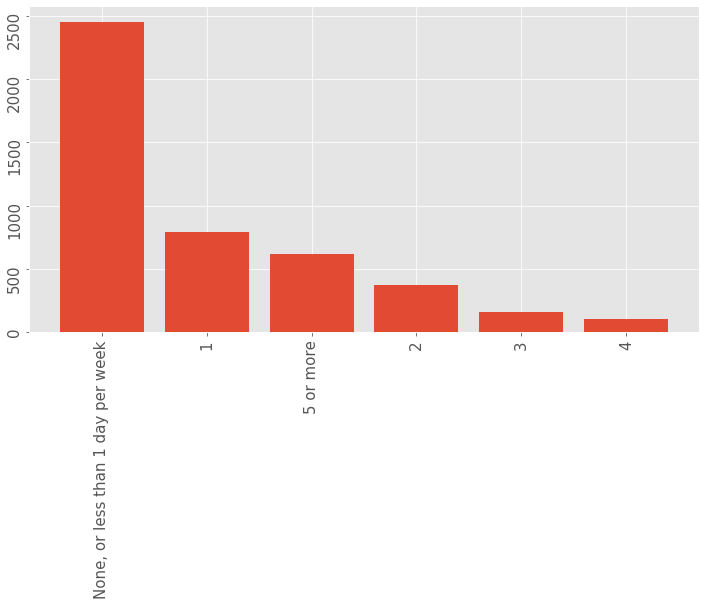

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, us['TelecommuteDaysPerWeek'].value_counts()))
ax.tick_params(rotation=90)

### Employment Sector

OHE

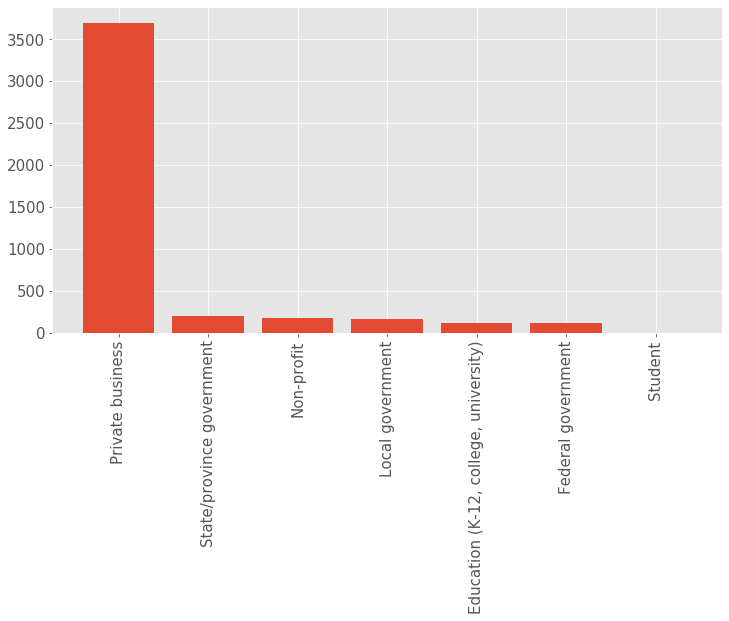

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, us['EmploymentSector'].value_counts()))

_ = ax.set_xticklabels(labels=us['EmploymentSector'].value_counts().index, rotation=90)

### Career Plans This Year

Decided to drop due to large number of Not Asked

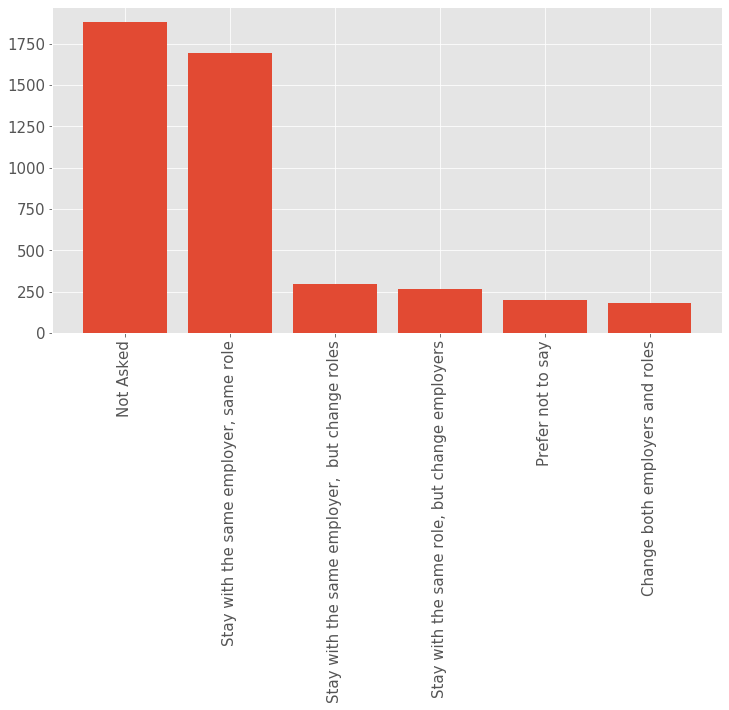

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, us['CareerPlansThisYear'].value_counts()))

_ = ax.set_xticklabels(labels=us['CareerPlansThisYear'].value_counts().index, rotation=90)

### Gender

Might have to drop gender due to high number of NaNs/Not Asked.

In [39]:
def clean_gender(row):
    if (row not in ['Male', 'Female']):
        return 'Not Asked'
    return row

In [40]:
us['Gender'].apply(clean_gender).value_counts()

Male         2266
Not Asked    1922
Female        321
Name: Gender, dtype: int64

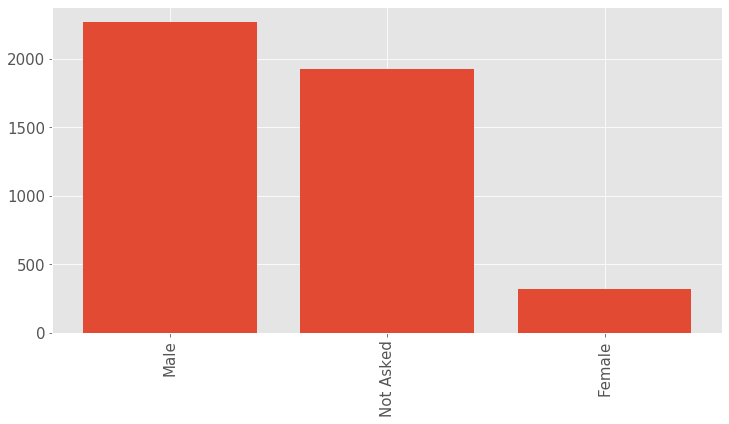

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, us['Gender'].apply(clean_gender).value_counts()))

_ = ax.set_xticklabels(labels=us['Gender'].apply(clean_gender).value_counts().index, rotation=90)

### Amount of Other Job Duties

Might have to exclude, due to high number of nans/No answers

In [42]:
us['OtherJobDuties'].replace('Not Asked', np.nan).isna().sum() / us['OtherJobDuties'].size

0.5021068973164782

In [43]:
ojd = us['OtherJobDuties'].dropna().str.replace('Not Asked', 'N/A').str.replace('\\(.*\\)', '', regex=True).apply(lambda x: x.split(','))

In [44]:
def filter_NA(row):
    if ('N/A' in row):
        return None
    return row

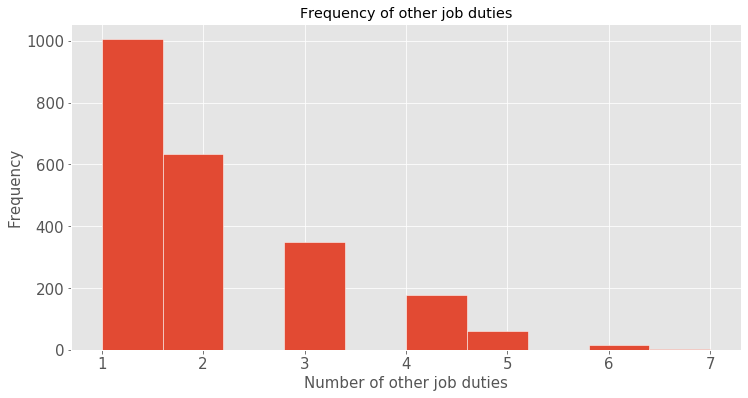

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_quant(ax, ojd.apply(filter_NA).dropna().apply(lambda x: len(x)), xlabel='Number of other job duties', ylabel='Frequency', 
                        title='Frequency of other job duties',edgecolor='white'))


### Feature Engineering

In [46]:
X = us.loc[:, features + target]

In [47]:
X.head()

,SalaryUSD,YearsWithThisDatabase,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,LookingForAnotherJob
0,200000.0,10,No,5,2,Masters,45,1,Private business,"Yes, but only passively (just curious)"
12,137500.0,16,No,6,4,None,55,5 or more,Private business,No
14,85000.0,8,No,2,None,Bachelors,50,"None, or less than 1 day per week",Private business,"Yes, but only passively (just curious)"
15,96000.0,5,No,5,None,Masters,45,1,Private business,"Yes, but only passively (just curious)"
17,66000.0,10,No,10,None,Associates,60,5 or more,Private business,"Yes, but only passively (just curious)"


### SalaryUSD

Cleaning erroneous values

In [48]:
X = X.drop(X[X['SalaryUSD'] < 100].index)

### YearsWithThisDatabase

Cleaning erroneous values

In [49]:
X[X['YearsWithThisDatabase'] > 100]

,SalaryUSD,YearsWithThisDatabase,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,LookingForAnotherJob
3498,95000.0,53716,No,1,4,Bachelors,45,"None, or less than 1 day per week",Private business,"Yes, but only passively (just curious)"
4181,98000.0,30331,No,2,3,Bachelors,50,1,Private business,"Yes, but only passively (just curious)"
5544,110000.0,2004,No,13,5,None,40,2,Private business,"Yes, but only passively (just curious)"
6327,89000.0,2011,No,3,None,Bachelors,40,"None, or less than 1 day per week",Private business,No
6619,131000.0,2000,No,3,None,None,35,"None, or less than 1 day per week",Private business,No


In [50]:
X = X.drop(X[X['YearsWithThisDatabase'] > 100].index)

### ManageStaff

Change it into a categorical variable

In [58]:
def transform_staff(row):
    return 0 if row == 'No' else 1

In [59]:
X.loc[:, 'ManageStaff'] = X['ManageStaff'].apply(transform_staff)

In [63]:
X.head()

,SalaryUSD,YearsWithThisDatabase,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,LookingForAnotherJob
0,200000.0,10,0,5,2,3,45,1,Private business,"Yes, but only passively (just curious)"
12,137500.0,16,0,6,4,0,55,5,Private business,No
14,85000.0,8,0,2,0,2,50,0,Private business,"Yes, but only passively (just curious)"
15,96000.0,5,0,5,0,3,45,1,Private business,"Yes, but only passively (just curious)"
17,66000.0,10,0,10,0,1,60,5,Private business,"Yes, but only passively (just curious)"


### Other People On Your Team

In [52]:
def transform_team(row):
    if (row == 'None'):
        return 0
    elif (row == 'More than 5'):
        return 6
    else:
        return int(row)

In [53]:
X.loc[:, 'OtherPeopleOnYourTeam'] = X['OtherPeopleOnYourTeam'].apply(transform_team)

### Education

In [61]:
def transform_education(row):
    if (row == 'None'):
        return 0
    elif (row == 'Associates'):
        return 1
    elif (row == 'Bachelors'):
        return 2
    elif (row == 'Masters'):
        return 3
    else:
        return 4

In [62]:
X.loc[:, 'Education'] = X['Education'].apply(transform_education)

### TelecommuteDaysPerWeek

In [55]:
def transform_telecommute(row):
    if ('None' in row):
        return 0
    elif (row == '5 or more'):
        return 5
    else:
        return int(row)

In [56]:
X.loc[:, 'TelecommuteDaysPerWeek'] = X['TelecommuteDaysPerWeek'].apply(transform_telecommute)

### EmploymentSector

In [120]:
X = pd.concat([X, pd.get_dummies(X['EmploymentSector'])], axis=1)
X = X.drop('EmploymentSector', axis=1)

### LookingForAnotherJob

In [64]:
def transform_another_job(row):
    if (row == 'No'):
        return 0
    elif (row == 'Yes, but only passively (just curious)'):
        return 1
    else:
        return 2

In [65]:
X.loc[:, 'LookingForAnotherJob'] = X['LookingForAnotherJob'].apply(transform_another_job)

In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4503 entries, 0 to 6891
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SalaryUSD               4503 non-null   float64
 1   YearsWithThisDatabase   4503 non-null   int64  
 2   ManageStaff             4503 non-null   int64  
 3   YearsWithThisTypeOfJob  4503 non-null   int64  
 4   OtherPeopleOnYourTeam   4503 non-null   int64  
 5   Education               4503 non-null   int64  
 6   HoursWorkedPerWeek      4503 non-null   int64  
 7   TelecommuteDaysPerWeek  4503 non-null   int64  
 8   EmploymentSector        4503 non-null   object 
 9   LookingForAnotherJob    4503 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 387.0+ KB


In [67]:
X.head()

,SalaryUSD,YearsWithThisDatabase,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,LookingForAnotherJob
0,200000.0,10,0,5,2,3,45,1,Private business,1
12,137500.0,16,0,6,4,0,55,5,Private business,0
14,85000.0,8,0,2,0,2,50,0,Private business,1
15,96000.0,5,0,5,0,3,45,1,Private business,1
17,66000.0,10,0,10,0,1,60,5,Private business,1


### More plotting for variables

In [125]:
sl = pd.concat([X['SalaryUSD'], X['LookingForAnotherJob']], axis=1)

In [126]:
sl_q3 = sl['SalaryUSD'].describe()['75%']
sl_q1 = sl['SalaryUSD'].describe()['25%']

sl_iqr = sl_q3 - sl_q1
sl = sl.loc[sl.loc[((sl['SalaryUSD'] < (sl_q3 + 1.5 * sl_iqr)) & (sl['SalaryUSD'] > (sl_q1 - 1.5 * sl_iqr))), 'SalaryUSD'].index]



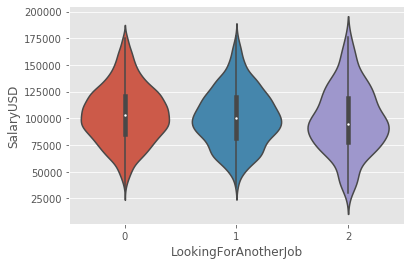

In [127]:
sns.violinplot(x='LookingForAnotherJob', y='SalaryUSD', data=sl)

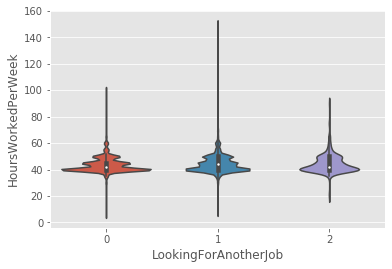

In [129]:
sns.violinplot(x='LookingForAnotherJob', y='HoursWorkedPerWeek', data=X)

In [72]:
not_looking = X[X['LookingForAnotherJob'] == 0]
passively_looking = X[X['LookingForAnotherJob'] == 1]
actively_looking = X[X['LookingForAnotherJob'] == 2]

In [73]:
not_looking

,SalaryUSD,YearsWithThisDatabase,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,LookingForAnotherJob
12,137500.0,16,0,6,4,0,55,5,Private business,0
18,101750.0,13,0,13,0,0,60,2,Private business,0
22,123000.0,7,0,7,2,2,45,3,Private business,0
23,100800.0,16,0,6,0,2,40,2,Private business,0
27,80000.0,3,0,3,1,2,45,0,Private business,0
...,...,...,...,...,...,...,...,...,...,...
6870,96000.0,12,0,12,2,1,40,5,Non-profit,0
6882,123000.0,16,0,6,0,2,45,1,Private business,0
6883,101500.0,8,0,9,3,2,43,1,Private business,0
6886,132000.0,20,0,20,3,2,45,5,Private business,0


In [74]:
passively_looking

,SalaryUSD,YearsWithThisDatabase,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,LookingForAnotherJob
0,200000.0,10,0,5,2,3,45,1,Private business,1
14,85000.0,8,0,2,0,2,50,0,Private business,1
15,96000.0,5,0,5,0,3,45,1,Private business,1
17,66000.0,10,0,10,0,1,60,5,Private business,1
21,78000.0,5,0,10,0,1,60,0,Private business,1
...,...,...,...,...,...,...,...,...,...,...
6856,92000.0,15,1,17,2,2,40,2,State/province government,1
6863,145000.0,10,0,7,2,2,45,1,Private business,1
6868,97000.0,4,0,4,2,2,40,0,Private business,1
6881,105000.0,15,0,15,3,2,45,0,Private business,1


In [75]:
actively_looking

,SalaryUSD,YearsWithThisDatabase,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,LookingForAnotherJob
61,97500.0,9,0,5,6,1,45,2,Private business,2
100,95000.0,15,0,11,1,2,40,0,Private business,2
117,87000.0,18,1,5,1,3,40,0,Private business,2
122,115000.0,12,0,10,1,0,40,0,Private business,2
134,70000.0,3,0,3,1,2,45,1,Private business,2
...,...,...,...,...,...,...,...,...,...,...
6812,80000.0,5,0,5,2,2,42,1,Private business,2
6819,85000.0,18,0,10,1,0,50,2,Private business,2
6830,136500.0,18,1,17,0,2,45,1,Private business,2
6861,160000.0,20,1,8,0,1,50,0,Private business,2


### Testing

In [76]:
import scipy.stats as stats

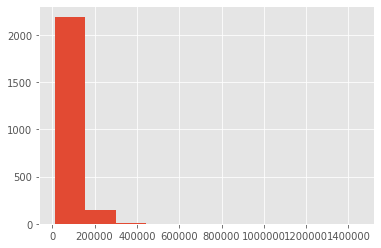

In [86]:
not_looking['SalaryUSD'].hist()

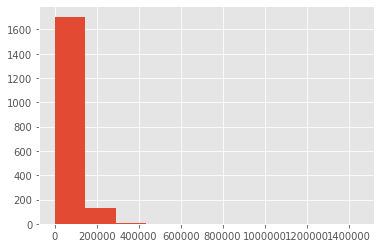

In [87]:
passively_looking['SalaryUSD'].hist()

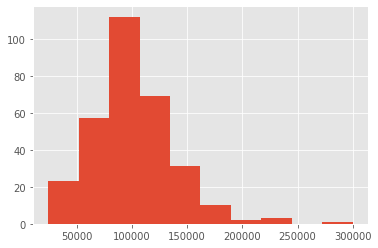

In [88]:
actively_looking['SalaryUSD'].hist()

In [130]:
nl_q1 = not_looking['SalaryUSD'].quantile(.25)
nl_q3 = not_looking['SalaryUSD'].quantile(.75)
nl_iqr = nl_q3 - nl_q1

nl_mask = ((not_looking['SalaryUSD'] <= nl_q3 + (1.5 * nl_iqr)) & (not_looking['SalaryUSD'] >= nl_q1 - (1.5 * nl_iqr)))

pl_q1 = passively_looking['SalaryUSD'].quantile(.25)
pl_q3 = passively_looking['SalaryUSD'].quantile(.75)
pl_iqr = pl_q3 - pl_q1

pl_mask = ((passively_looking['SalaryUSD'] <= pl_q3 + (1.5 * pl_iqr)) & (passively_looking['SalaryUSD'] >= pl_q1 - (1.5 * pl_iqr)))

al_q1 = actively_looking['SalaryUSD'].quantile(.25)
al_q3 = actively_looking['SalaryUSD'].quantile(.75)
al_iqr = al_q3 - al_q1

al_mask = ((actively_looking['SalaryUSD'] <= al_q3 + (1.5 * al_iqr)) & (actively_looking['SalaryUSD'] >= al_q1 - (1.5 * al_iqr)))

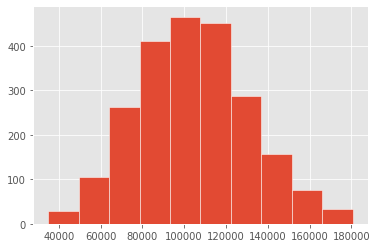

In [132]:
not_looking.loc[nl_mask, 'SalaryUSD'].hist(edgecolor='white')

In [133]:
not_looking.loc[nl_mask, 'SalaryUSD'].var()

725775840.2710052

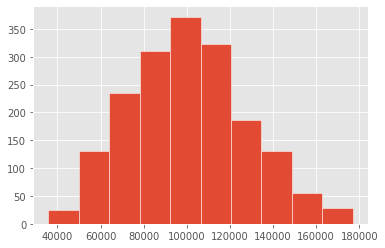

In [134]:
passively_looking.loc[pl_mask, 'SalaryUSD'].hist(edgecolor='white')

In [135]:
passively_looking.loc[pl_mask, 'SalaryUSD'].var()

716397637.2121731

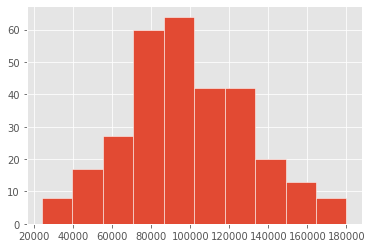

In [136]:
actively_looking.loc[al_mask, 'SalaryUSD'].hist(edgecolor='white')

In [137]:
actively_looking.loc[al_mask, 'SalaryUSD'].var()

1001119551.3440312

### P-value of 0.05

**Salary difference**

In [138]:
nl_adj = not_looking.loc[nl_mask, 'SalaryUSD']
pl_adj = passively_looking.loc[pl_mask, 'SalaryUSD']
al_adj = actively_looking.loc[al_mask, 'SalaryUSD']

In [215]:
stats.ttest_ind(nl_adj, pl_adj)



Ttest_indResult(statistic=4.066666555799696, pvalue=4.859192220036068e-05)

In [214]:
stats.ttest_ind(nl_adj, al_adj, equal_var=False)



Ttest_indResult(statistic=3.065831165357773, pvalue=0.0023347436647396217)

In [213]:
stats.ttest_ind(pl_adj, al_adj, equal_var=False)



Ttest_indResult(statistic=1.2467507211855793, pvalue=0.21326640505817215)

In [148]:
# Not usable due to unequal sample size of actively looking compared to not and passively looking
# stats.f_oneway(nl_adj, pl_adj, al_adj)

**Hours of Work Per Week difference**

In [157]:
nl_hours = not_looking['HoursWorkedPerWeek']
pl_hours = passively_looking['HoursWorkedPerWeek']
al_hours = actively_looking['HoursWorkedPerWeek']

In [249]:
nl_q1 = nl_hours.quantile(.25)
nl_q3 = nl_hours.quantile(.75)
nl_iqr = nl_q3 - nl_q1

nl_mask = ((nl_hours <= nl_q3 + (1.5 * nl_iqr)) & (nl_hours >= nl_q1 - (1.5 * nl_iqr)))

pl_q1 = pl_hours.quantile(.25)
pl_q3 = pl_hours.quantile(.75)
pl_iqr = pl_q3 - pl_q1

pl_mask = ((pl_hours <= pl_q3 + (1.5 * pl_iqr)) & (pl_hours >= pl_q1 - (1.5 * pl_iqr)))

al_q1 = al_hours.quantile(.25)
al_q3 = al_hours.quantile(.75)
al_iqr = al_q3 - al_q1

al_mask = ((al_hours <= al_q3 + (1.5 * al_iqr)) & (al_hours >= al_q1 - (1.5 * al_iqr)))

In [251]:
stats.ttest_ind(nl_hours[nl_mask], pl_hours[pl_mask])

Ttest_indResult(statistic=-8.879469669599349, pvalue=9.940722572963885e-19)

In [252]:
stats.ttest_ind(pl_hours[pl_mask], al_hours[al_mask], equal_var=False)

Ttest_indResult(statistic=-0.044743107360455225, pvalue=0.9643339009413094)

In [253]:
stats.ttest_ind(nl_hours[nl_mask], al_hours[al_mask], equal_var=False)

Ttest_indResult(statistic=-4.048445961402833, pvalue=6.381045564993862e-05)

**Education difference**

In [177]:
nl_edu = not_looking['Education'].value_counts().sort_index()
pl_edu = passively_looking['Education'].value_counts().sort_index()
al_edu = actively_looking['Education'].value_counts().sort_index()

In [201]:
cont_table = np.array([nl_edu.values, pl_edu.values, al_edu.values])

In [203]:
chi, p, dof, expected = stats.chi2_contingency(cont_table)

In [219]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


**Other People On Your Team difference**

In [227]:
nl_people = not_looking['OtherPeopleOnYourTeam'].value_counts().sort_index()
pl_people = passively_looking['OtherPeopleOnYourTeam'].value_counts().sort_index()
al_people = actively_looking['OtherPeopleOnYourTeam'].value_counts().sort_index()

In [229]:
cont_table = np.array([nl_people.values, pl_people.values, al_people.values])

In [230]:
chi, p, dof, expected = stats.chi2_contingency(cont_table)

In [231]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


**TelecommuteDaysPerWeek**

In [244]:
nl_tele = not_looking['TelecommuteDaysPerWeek'].value_counts().sort_index()
pl_tele = passively_looking['TelecommuteDaysPerWeek'].value_counts().sort_index()
al_tele = actively_looking['TelecommuteDaysPerWeek'].value_counts().sort_index()

In [245]:
cont_table = np.array([nl_tele.values, pl_tele.values, al_tele.values])

In [246]:
chi, p, dof, expected = stats.chi2_contingency(cont_table)

In [247]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


### Future plans

In [ ]:
# countries_more_than_ten = countries.index[countries > 10]
# df = df[df['Country'].isin(countries_more_than_ten)]
# df.head()

### Predictive pipelines